# Segment geospatial - Segmentation with text prompts

[Segment-geospatial documentation](https://samgeo.gishub.org/)

In [1]:
import leafmap
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from samgeo import split_raster
from samgeo.text_sam import LangSAM

Create a interactive map

In [3]:
m = leafmap.Map(height="700px", width="1000px")
m.add_basemap("Satellite")
m.add_layer_manager()

In [4]:
image_name = '690000_5335000'
image = f'../data/Munich/2003/raw/{image_name}.tif'

Display the image on the map.

In [5]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Initialize LangSAM

In [5]:
%env CUDA_VISIBLE_DEVICES="" # to run on CPU

env: CUDA_VISIBLE_DEVICES="" # to run on CPU


In [6]:
SAM_CHECKPOINT = "../segment-anything/checkpoints/sam_vit_l_0b3195.pth"
MODEL_TYPE = "vit_l"
sam = LangSAM(model_type=MODEL_TYPE, checkpoint=SAM_CHECKPOINT)

final text_encoder_type: bert-base-uncased


## Segment images

`box_threshold`: This value is used for object detection in the image. A higher value makes the model more selective, identifying only the most confident object instances, leading to fewer overall detections. A lower value, conversely, makes the model more tolerant, leading to increased detections, including potentially less confident ones.

`text_threshold`: This value is used to associate the detected objects with the provided text prompt. A higher value requires a stronger association between the object and the text prompt, leading to more precise but potentially fewer associations. A lower value allows for looser associations, which could increase the number of associations but also introduce less precise matches.

### Segment in batches

In [7]:
WORK_DIR = "tmp"
tiles_dir = f"{WORK_DIR}/tiles"
mask_dir = f"{WORK_DIR}/masks"

text_prompt = "tree, gras"

# empty samgeo_tmp/masks and samgeo_tmp/tiles directories
os.system(f"rm -rf {tiles_dir}/*")
os.system(f"rm -rf {mask_dir}/*")

# split images into tiles
split_raster(image, out_dir=tiles_dir, tile_size=(500, 500), overlap=0)

box_threshold = 0.25
text_threshold = 0.5

sam.predict_batch(
    images=tiles_dir,
    out_dir=mask_dir,
    text_prompt=text_prompt,
    box_threshold=box_threshold,
    text_threshold=text_threshold,
    mask_multiplier=255,
    merge=True,
)

Processing image 01 of 25: tmp/tiles/tile_0_0.tif...
Processing image 02 of 25: tmp/tiles/tile_0_1.tif...
Processing image 03 of 25: tmp/tiles/tile_0_2.tif...
Processing image 04 of 25: tmp/tiles/tile_0_3.tif...
Processing image 05 of 25: tmp/tiles/tile_0_4.tif...
Processing image 06 of 25: tmp/tiles/tile_1_0.tif...
Processing image 07 of 25: tmp/tiles/tile_1_1.tif...
Processing image 08 of 25: tmp/tiles/tile_1_2.tif...
Processing image 09 of 25: tmp/tiles/tile_1_3.tif...
Processing image 10 of 25: tmp/tiles/tile_1_4.tif...
Processing image 11 of 25: tmp/tiles/tile_2_0.tif...
Processing image 12 of 25: tmp/tiles/tile_2_1.tif...


2023-11-30 21:57:18.540726: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Processing image 13 of 25: tmp/tiles/tile_2_2.tif...
Processing image 14 of 25: tmp/tiles/tile_2_3.tif...
Processing image 15 of 25: tmp/tiles/tile_2_4.tif...
Processing image 16 of 25: tmp/tiles/tile_3_0.tif...
Processing image 17 of 25: tmp/tiles/tile_3_1.tif...
Processing image 18 of 25: tmp/tiles/tile_3_2.tif...
Processing image 19 of 25: tmp/tiles/tile_3_3.tif...
Processing image 20 of 25: tmp/tiles/tile_3_4.tif...
Processing image 21 of 25: tmp/tiles/tile_4_0.tif...
Processing image 22 of 25: tmp/tiles/tile_4_1.tif...
Processing image 23 of 25: tmp/tiles/tile_4_2.tif...
Processing image 24 of 25: tmp/tiles/tile_4_3.tif...
Processing image 25 of 25: tmp/tiles/tile_4_4.tif...
Saved the merged prediction to tmp/masks/merged.tif.


In [35]:
m.add_raster('tmp/masks/merged.tif', cmap='Greens', nodata=0, layer_name='Mask')
m

Map(bottom=1454616.0, center=[48.214035807386104, 11.589717864990234], controls=(ZoomControl(options=['positio…

In [7]:
def plot_overlay(image_path, mask_math, alpha=0.5, title=None, output=None):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_math)

    # Convert black regions in the mask to full color in the original image
    mask[np.where((mask == [0, 0, 0]).all(axis=2))] = image[np.where((mask == [0, 0, 0]).all(axis=2))]
    # Convert white regions in the mask to green tones in the overlay
    mask[np.where((mask == [255, 255, 255]).all(axis=2))] = [0, 255, 0]

    # Apply the mask
    overlay = cv2.addWeighted(image, 1 - alpha, mask, alpha, 0)

    if output:
        cv2.imwrite(output, overlay)
        
    # convert from BGR to RGB for matplotlib
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Display the result using matplotlib
    plt.figure(figsize=(15, 10))
    plt.imshow(overlay)
    if title:
        plt.title(title)
    plt.axis('off')
    # if output:
    #     plt.savefig(output, bbox_inches='tight')
    plt.show()

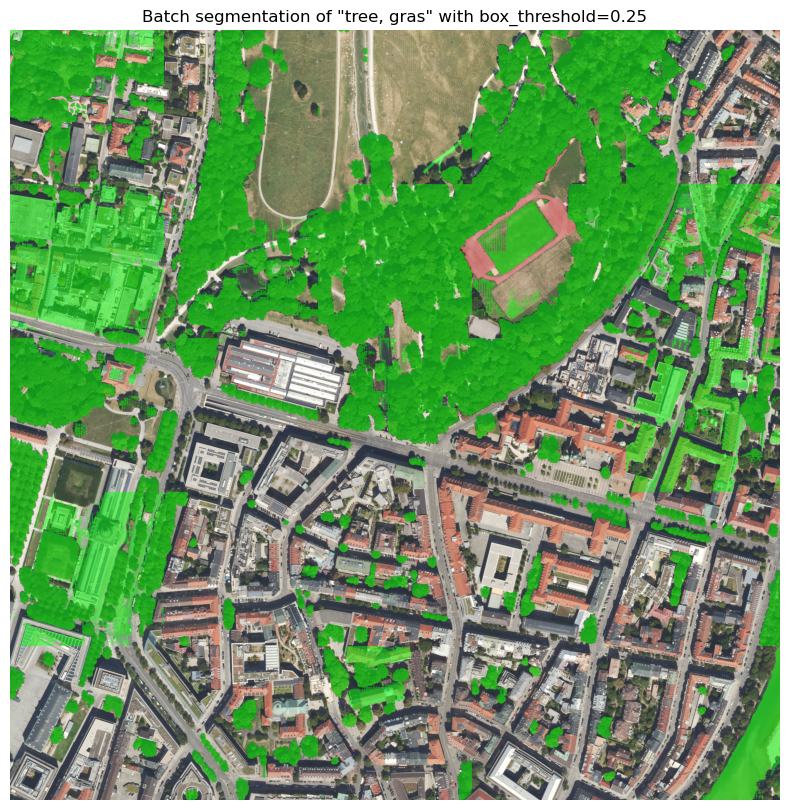

In [9]:
# move created mask to results folder
mask_path = f"results/{image_name}_batch_mask_{box_threshold}_{text_threshold}.tif"
os.system(f"mv {mask_dir}/merged.tif {mask_path}")

title = f'Batch segmentation of "{text_prompt}" with box_threshold={box_threshold}'
output_path = f'results/{image_name}_batch_overlay_{box_threshold}_{text_threshold}.png'
plot_overlay(image, mask_path,  output=output_path, title=title)

### Segment whole image (no batches)

In [11]:
text_prompt = "tree, gras"
mask_path = f'results/{image_name}_mask.tif'
box_threshold = 0.25
text_threshold = 0.5
sam.predict(image, text_prompt, 
            box_threshold=box_threshold, 
            text_threshold=text_threshold, 
            output=mask_path
            )

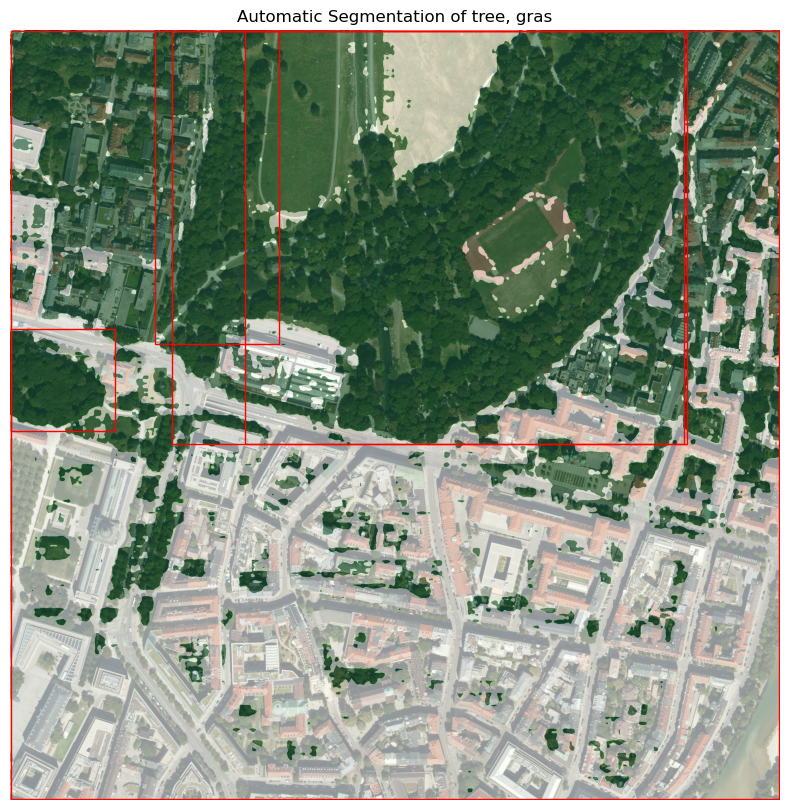

In [12]:
sam.show_anns(
    cmap='Greens',
    add_boxes=True,
    alpha=0.5,
    title=f'Automatic Segmentation of {text_prompt}',
)

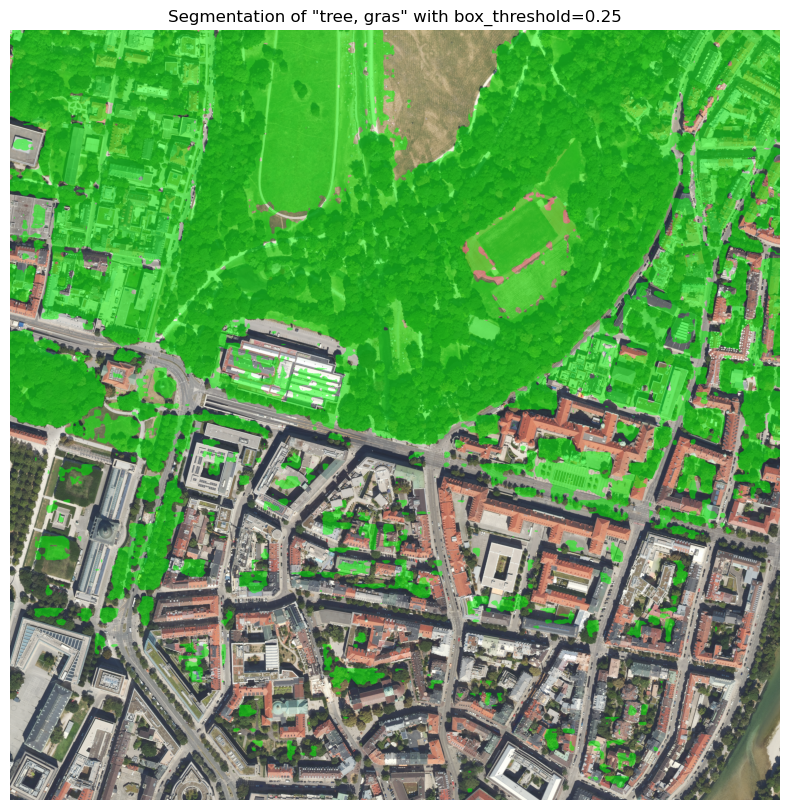

In [14]:
output_path = f'results/{image_name}_overlay_{box_threshold}_{text_threshold}.png'
title = f'Segmentation of "{text_prompt}" with box_threshold={box_threshold}'
plot_overlay(image, mask_path,  output=output_path, title=title)